# Part 5: New Yorkers’ Commute behavior


In [196]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import logit
import statsmodels.api as sm
import scipy as sp
import geopandas as gpd
from shapely import wkt

In [197]:
#### Store the url string that hosts our .csv files 
#### Copy data files to the 2022CMS folder that should be in the same folder as this notebook
urlday = "C:\\Users\\Administrator\\Downloads\\project_data\\Citywide_Mobility_Survey_-_Day_2022.csv"
urlhhl = "C:\\Users\\Administrator\\Downloads\\project_data\\Citywide_Mobility_Survey_-_Household_2022.csv"
urlper = "C:\\Users\\Administrator\\Downloads\\project_data\\Citywide_Mobility_Survey_-_Person_2022.csv"
urlzon = "C:\\Users\\Administrator\\Downloads\\project_data\\Citywide_Mobility_Survey_-_Survey_Zones.csv"
urltrp = "C:\\Users\\Administrator\\Downloads\\project_data\\Citywide_Mobility_Survey_-_Trip_2022.csv"
urlveh = "C:\\Users\\Administrator\\Downloads\\project_data\\Citywide_Mobility_Survey_-_Vehicle_2022.csv"

#### Read the .csv file using `pandas` libriary and store it as a `pandas` Data Frame
dday = pd.read_csv(urlday)
dhhl = pd.read_csv(urlhhl)
dper = pd.read_csv(urlper)
dzon = pd.read_csv(urlzon)
dtrp = pd.read_csv(urltrp)
dveh = pd.read_csv(urlveh)

#### Finally, let's make sure that all columns are displayed
pd.set_option('display.max_columns', None)

In [198]:
zone_nums = list(range(12))
zone_names = {k: v for k, v in enumerate(dzon['CMS Zone'])}

dtrp['o_cms_zone_name'] = dtrp['o_cms_zone'].map(zone_names)
dtrp['d_cms_zone_name'] = dtrp['d_cms_zone'].map(zone_names)

tripzone_d = dtrp.groupby('d_cms_zone_name').size()
tripzone_o = dtrp.groupby('o_cms_zone_name').size()

all_zones = set(zone_names.values())
o_zones_with_data = set(tripzone_o.index)
d_zones_with_data = set(tripzone_d.index)

missing_origins = all_zones - o_zones_with_data
missing_destinations = all_zones - d_zones_with_data

print("Origin zones with no trips:", missing_origins)
print("Destination zones with no trips:", missing_destinations)

tripzone_o = tripzone_o.reindex(all_zones, fill_value=0)
tripzone_d = tripzone_d.reindex(all_zones, fill_value=0)

tripzone = pd.crosstab(dtrp['o_cms_zone_name'], dtrp['d_cms_zone_name'])
tripzone = tripzone.reindex(index=all_zones, columns=all_zones, fill_value=0)

print(f"Number of trips from each origin zone:\n{tripzone_o}\n")
print(f"Number of trips to each destination zone:\n{tripzone_d}\n")

Origin zones with no trips: {'Middle Queens'}
Destination zones with no trips: {'Middle Queens'}
Number of trips from each origin zone:
o_cms_zone_name
Southern Bronx      5081
Outer Brooklyn      7462
Inner Queens        7223
JFK                 4798
LGA                20783
Staten Island       8072
Manhattan Core      4848
Inner Brooklyn      5127
Middle Queens          0
Upper Manhattan    11395
Outer Queens        4776
Northern Bronx      6774
dtype: int64

Number of trips to each destination zone:
d_cms_zone_name
Southern Bronx      5050
Outer Brooklyn      7403
Inner Queens        7215
JFK                 4778
LGA                20903
Staten Island       8166
Manhattan Core      4826
Inner Brooklyn      5147
Middle Queens          0
Upper Manhattan    11358
Outer Queens        4750
Northern Bronx      6743
dtype: int64



In [199]:
dpt = pd.merge(dper, dtrp, on='person_id',how='outer')
dpt.rename(columns={'hh_id_x': 'hh_id'}, inplace=True)
dpth = pd.merge(dpt, dhhl, on='hh_id',how='outer')
dpth.describe()

,hh_id,num_trips_x,num_days_complete_x,person_id,person_num_x,is_participant,phone_type,relationship,age,r_age,race_1,race_2,race_3,race_4,race_5,race_6,race_997,race_999,r_race,ethnicity_1,ethnicity_2,ethnicity_3,ethnicity_4,ethnicity_5,ethnicity_997,ethnicity_999,r_ethnicity,gender,can_drive,disability,disability_follow_1,disability_follow_2,disability_follow_3,disability_follow_4,disability_follow_5,disability_follow_6,disability_follow_996,disability_follow_999,education,employment,worker,num_jobs,job_type,industry,work_in_region,work_county,work_cms_zone,wfh_policy,commute_freq,telework_freq,r_telework_freq,work_mode,r_work_mode,work_mode_own,work_mode_auto,work_park_loc,work_park_pay,work_park_cost,work_park_amount,work_mode_taxi,work_mode_bus,work_mode_rail,work_mode_ferry,work_mode_bike,work_bike_park,work_mode_scooter,work_scooter_park,student,r_student,school_type,r_school_type,school_in_region,school_county,school_freq,remote_class_freq,school_mode,school_mode_own,school_mode_auto,school_park_loc,school_park_cost,school_park_amount,school_mode_taxi,school_mode_bus,school_mode_rail,school_mode_ferry,school_mode_bike,school_bike_park,school_mode_scooter,school_scooter_park,home_park_1,home_park_2,home_park_3,home_park_pay,home_park_cost,home_park_amount,second_home,second_home_freq,second_home_in_region,second_home_county,share_1,share_2,share_3,share_4,share_5,share_6,share_996,tnc_freq,tnc_purp,carshare_freq,vehicle,bike_freq,bike_purp_1,bike_purp_2,bike_purp_3,bike_purp_4,bike_purp_5,bike_purp_6,bike_purp_997,no_bike_nyc_1,no_bike_nyc_2,no_bike_nyc_3,no_bike_nyc_4,no_bike_nyc_5,no_bike_nyc_6,no_bike_nyc_7,no_bike_nyc_9,no_bike_nyc_997,no_freq_bike_nyc_1,no_freq_bike_nyc_2,no_freq_bike_nyc_3,no_freq_bike_nyc_4,no_freq_bike_nyc_5,no_freq_bike_nyc_6,no_freq_bike_nyc_997,no_freq_bike_nyc_other,bike_stolen,citi_bike_freq,citi_bike_type,citi_bike_pay,citi_bike_alt_mode,no_bike_share_1,no_bike_share_2,no_bike_share_3,no_bike_share_4,no_bike_share_5,no_bike_share_6,no_bike_share_7,no_bike_share_8,no_bike_share_997,micromobility_devices_204,micromobility_devices_83,micromobility_devices_205,micromobility_devices_73,micromobility_devices_206,micromobility_devices_207,micromobility_devices_996,kid_accompany,kid_mode,r_kid_mode,kid_mode_own,kid_mode_auto,kid_mode_taxi,kid_mode_bus,kid_mode_rail,kid_mode_ferry,kid_access,kid_egress,kid_mode_bike,kid_mode_scooter,harassment,harassment_change_1,harassment_change_2,harassment_change_3,harassment_change_4,harassment_change_5,harassment_change_6,harassment_change_7,harassment_change_8,harassment_change_9,harassment_change_10,harassment_change_996,harassment_change_997,person_weight,hh_id_y,person_num_y,day_id,travel_dow,day_num,is_complete,linked_trip_id,linked_leg_num,trip_id,trip_num,day_is_complete,arrive_dow,depart_dow,o_in_region,o_county,d_in_region,d_county,mode_type_nyc,r_mode_type_nyc,mode_1,mode_2,mode_3,mode_priority_nyc,transit_access,r_transit_access,transit_egress,r_transit_egress,park_location,park_type,park_pay,park_cost,ev_charge_station,ev_charge_station_level_1,ev_charge_station_level_2,ev_charge_station_level_3,ev_charge_station_level_4,ev_charge_station_level_5,ev_charge_station_level_997,ev_charge_station_level_998,tnc_type,taxi_type,taxi_pay,taxi_cost,transit_type,bike_park_loc,scooter_park_location,num_travelers,num_hh_travelers,num_non_hh_travelers,hh_member_1,hh_member_2,hh_member_3,hh_member_4,hh_member_5,hh_member_6,hh_member_7,hh_member_8,hh_member_9,hh_member_10,hh_member_11,hh_member_12,driver,o_purpose,o_purpose_category,d_purpose,d_purpose_category,d_purpose_category_linked,r_d_purpose_category_linked,work_trip,depart_hour,depart_minute,depart_seconds,r_timeofday,arrive_hour,arrive_minute,arrive_second,duration_minutes,r_duration_minutes,duration_seconds,distance_miles,r_distance_miles,dwell_mins,high_speed_flag,long_distance_flag,o_cms_zone,d_cms_zone,unlinked_trip,o_location_type,d_location_type,trip_wkday_weight,trip_svnday_weight,hh_cms_zone_gp,p

In [200]:
dpth = dpth[(dpth['d_purpose_category_linked'] == 2) | (dpth['d_purpose_category_linked'] == 3)]
dpth = dpth[dpth['commute_freq'] < 7]
print("total number of commute trips:", len(dpth))

total number of commute trips: 14688


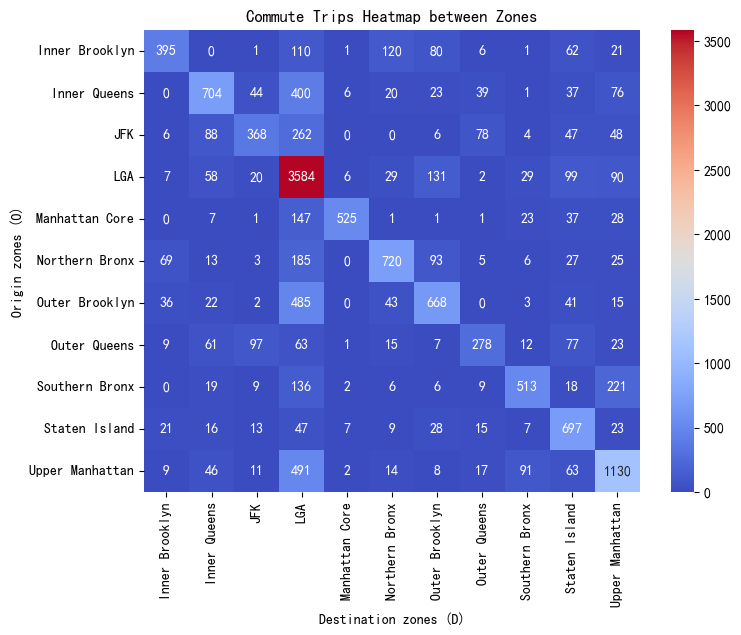

In [201]:
dpt_commute_o = dpth['o_cms_zone_name']
dpt_commute_d = dpth['d_cms_zone_name']
commute_tripzone = pd.crosstab(dpt_commute_o, dpt_commute_d)

commute_tripzone

plt.figure(figsize=(8, 6))
commute_tripzone_heatmap = sns.heatmap(commute_tripzone, annot=True,  cmap="coolwarm", fmt="d")
plt.xlabel('Destination zones (D)')
plt.ylabel('Origin zones (O)')
plt.title('Commute Trips Heatmap between Zones')
plt.show()

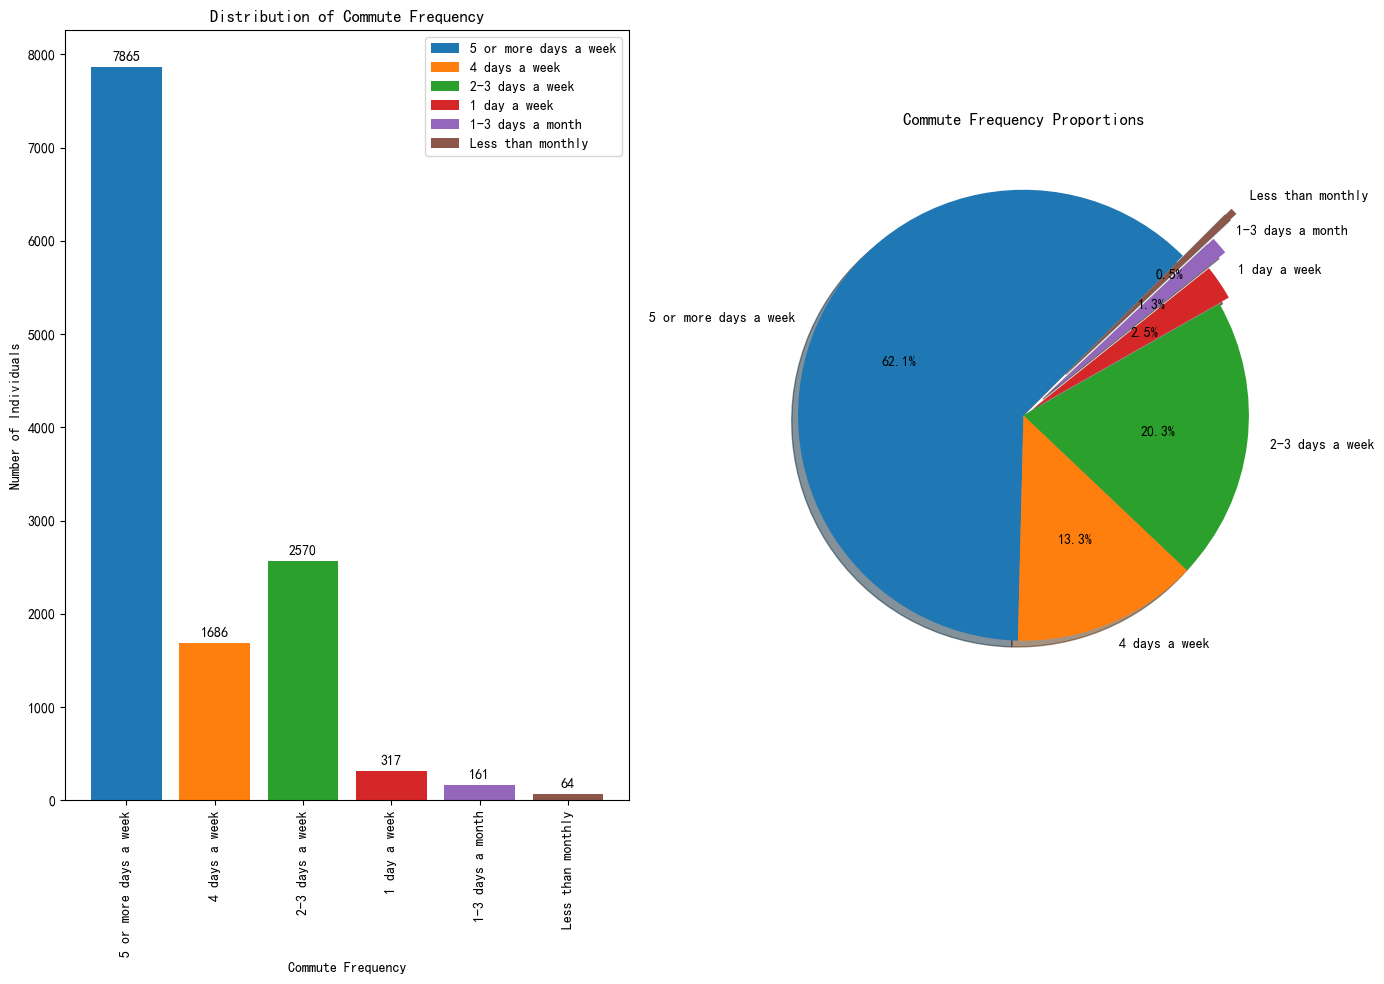

In [226]:
dpth_commute_freq = dpth.groupby('commute_freq').size()
dpth_commute_freq_name = {1:'5 or more days a week', 2:'4 days a week', 3:'2-3 days a week', 4:'1 day a week', 5:'1-3 days a month', 6:'Less than monthly'}
dpth_commute_freq.index = dpth_commute_freq.index.map(dpth_commute_freq_name)


cmap = plt.get_cmap('tab10')
plt.figure(figsize=(16,10))

plt.subplot(121)
com_o_bar = plt.bar(dpth_commute_freq.index, dpth_commute_freq.values, color=cmap.colors)
plt.bar_label(com_o_bar,padding=3)
plt.xlabel('Commute Frequency')
plt.ylabel('Number of Individuals')
plt.title('Distribution of Commute Frequency')
plt.legend(com_o_bar, dpth_commute_freq.index)
plt.xticks(rotation=90)

plt.subplot(122)
com_o_pie = plt.pie(dpth_commute_freq.values, labels=dpth_commute_freq.index, autopct='%1.1f%%', explode=(0, 0, 0, 0.05, 0.15, 0.3), colors=cmap.colors, startangle=45, shadow=True)
plt.title('Commute Frequency Proportions')
plt.show()

In [205]:
dpth = dpth[dpth['r_mode_type_nyc'] != 995]

trip_mode_type = {1:'Vehicle',
                  2:'Bus',
                  3:'Rail',
                  4:'Walk',
                  5:'Bike',
                  6:'Other'}

dpth['mode_type'] = dpth['r_mode_type_nyc'].map(trip_mode_type)

com_trip_type = dpth.groupby('mode_type').size()

dpth.groupby('mode_type').size()

mode_type
Bike        324
Bus         908
Other       257
Rail       4240
Vehicle    3055
Walk       5617
dtype: int64

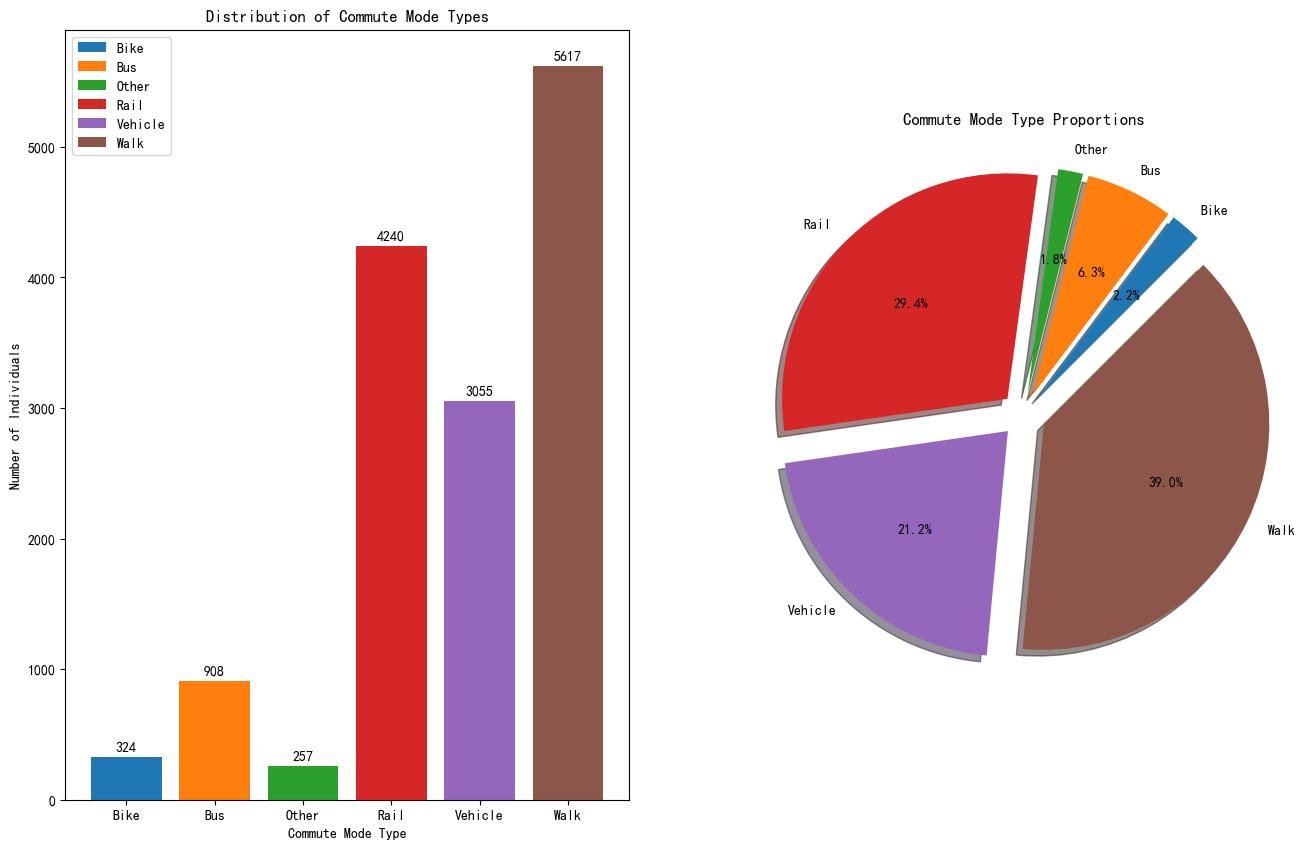

In [215]:
plt.figure(figsize=(16,10))
plt.subplot(121)
com_type_bar = plt.bar(com_trip_type.index, com_trip_type.values, color=cmap.colors)
plt.bar_label(com_type_bar,padding=3)
plt.xlabel('Commute Mode Type')
plt.legend(com_type_bar, com_trip_type.index)
plt.ylabel('Number of Individuals')
plt.title('Distribution of Commute Mode Types')

plt.subplot(122)
com_type_pie = plt.pie(com_trip_type.values, labels=com_trip_type.index, autopct='%1.1f%%', explode=(0.1, 0.1, 0.1, 0.1, 0.1, 0.1), colors=cmap.colors, startangle=45, shadow=True)
plt.title('Commute Mode Type Proportions')

plt.show()

In [221]:
dpth = dpth[dpth['r_distance_miles'] != 995]
trip_miles_type = {1:'Less than 1 mile',
                  2:'1 to 2 miles',
                  3:'2 to 5 miles',
                  4:'5 to 10 miles',
                  5:'10 miles or more'}
dpth['trip_miles_type'] = dpth['r_distance_miles'].map(trip_miles_type)

com_distance = dpth.groupby('trip_miles_type').size()
com_distance

trip_miles_type
1 to 2 miles        1330
10 miles or more    1069
2 to 5 miles        2244
5 to 10 miles       1550
Less than 1 mile    6470
dtype: int64

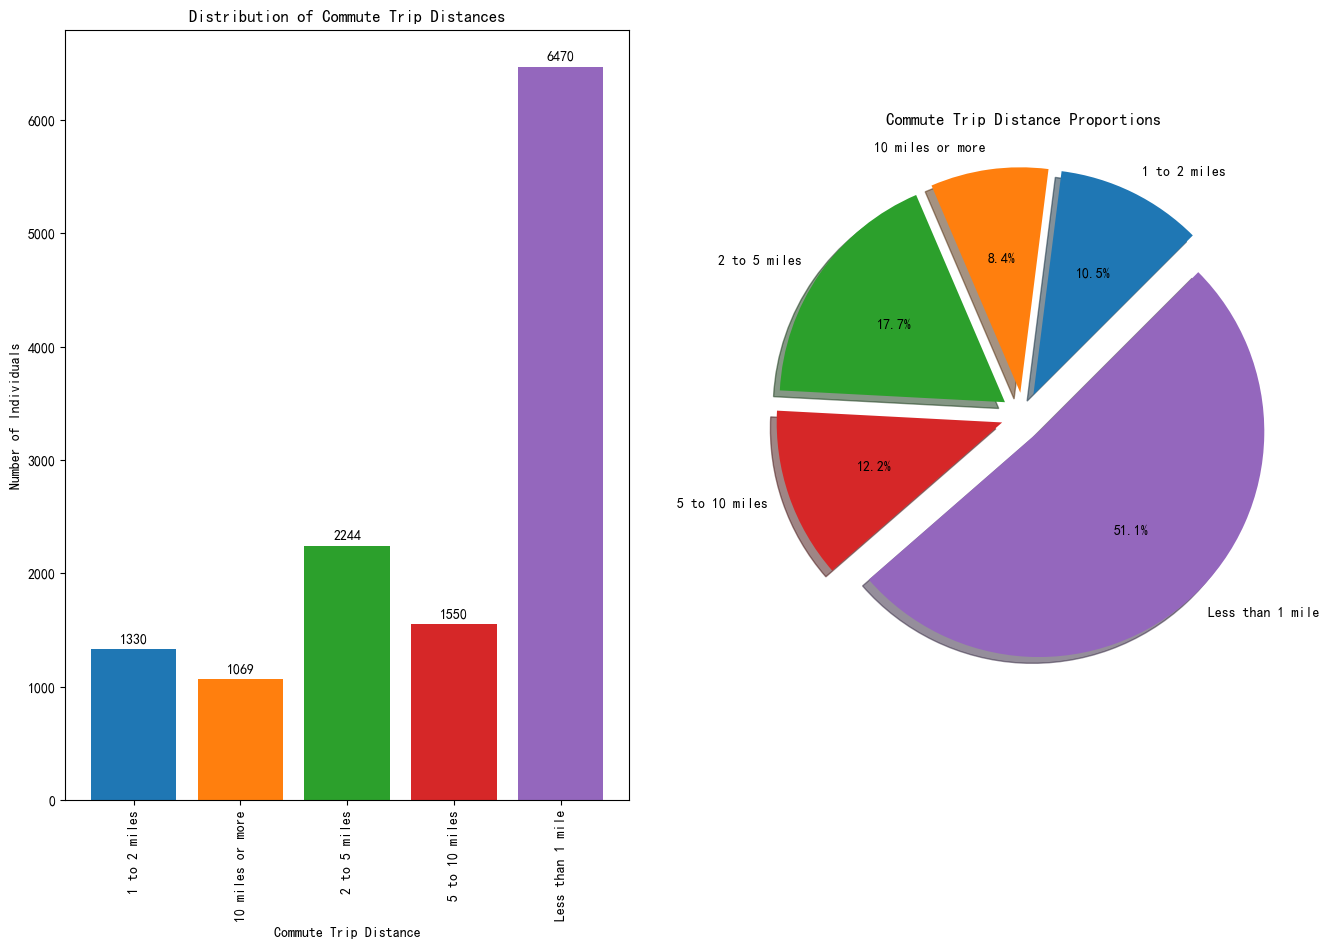

In [224]:
plt.figure(figsize=(16,10))
plt.subplot(121)
com_distance_bar = plt.bar(com_distance.index, com_distance.values, color=cmap.colors)
plt.bar_label(com_distance_bar,padding=3)
plt.xticks(rotation=90)
plt.xlabel('Commute Trip Distance')
plt.ylabel('Number of Individuals')
plt.title('Distribution of Commute Trip Distances')


plt.subplot(122)
com_distance_pie = plt.pie(com_distance.values, labels=com_distance.index, autopct='%1.1f%%', explode=(0.1, 0.1, 0.1, 0.1, 0.1), colors=cmap.colors, startangle=45, shadow=True)
plt.title('Commute Trip Distance Proportions')
plt.show()

In [229]:
dpth = dpth[dpth['r_duration_minutes'] != 995]
trip_time_type = {1:'Less than 10 minutes',
                  2:'10 to 20 minutes',
                  3:'20 minutes to 1 hour',
                  4:'1 hour or more'}

dpth['time_type'] = dpth['r_duration_minutes'].map(trip_time_type)
com_time = dpth.groupby('time_type').size()
com_time

time_type
1 hour or more           805
10 to 20 minutes        2998
20 minutes to 1 hour    3166
Less than 10 minutes    5694
dtype: int64

In [231]:
com_time_distance = pd.crosstab(dpth['time_type'], dpth['trip_miles_type'])
com_time_distance

trip_miles_type,1 to 2 miles,10 miles or more,2 to 5 miles,5 to 10 miles,Less than 1 mile
time_type,,,,,
1 hour or more,34,394,114,198,65
10 to 20 minutes,485,27,949,201,1336
20 minutes to 1 hour,270,638,924,1115,219
Less than 10 minutes,541,10,257,36,4850


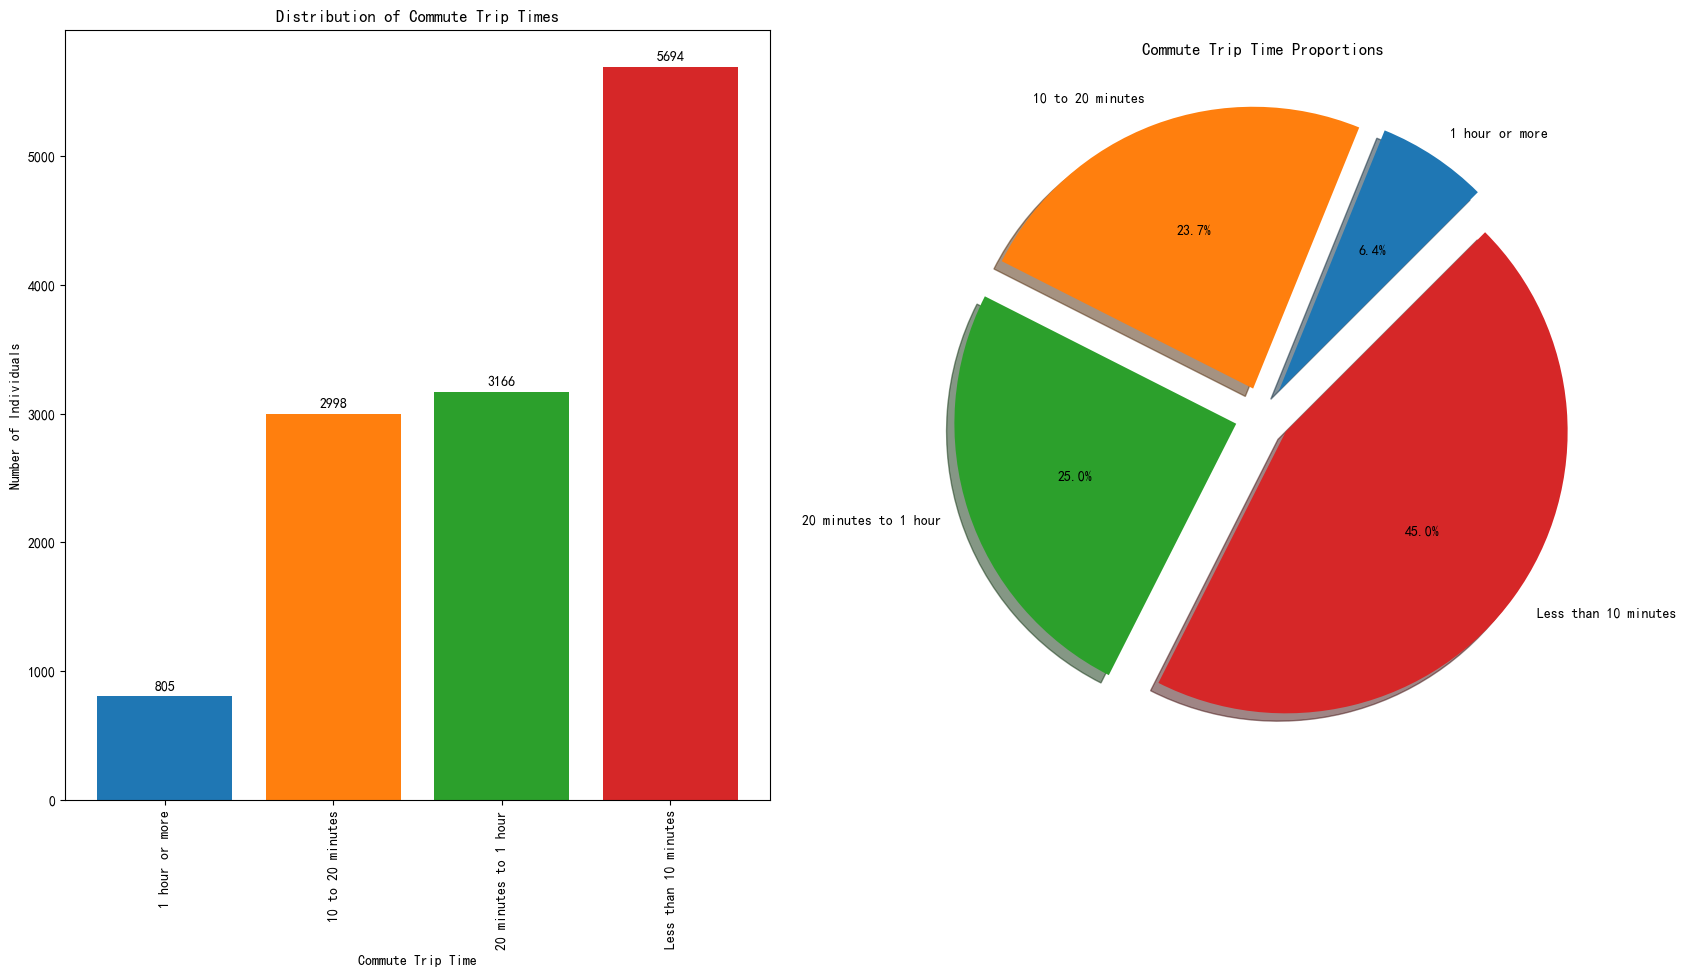

In [236]:
plt.figure(figsize=(20,10))
plt.subplot(121)
com_time_bar = plt.bar(com_time.index, com_time.values, color = cmap.colors)
plt.bar_label(com_time_bar, padding = 3)
plt.xlabel('Commute Trip Time')
plt.ylabel('Number of Individuals')
plt.title('Distribution of Commute Trip Times')
plt.xticks(rotation=90)

plt.subplot(122)
com_time_pie = plt.pie(com_time.values, labels = com_time.index, autopct='%1.1f%%', explode=(0.1, 0.1, 0.1, 0.1), colors=cmap.colors, startangle=45, shadow=True)
plt.title('Commute Trip Time Proportions')
plt.show()